<a href="https://colab.research.google.com/github/miamvmian/Sk-ML-FNO-Project-2024/blob/main/fno-main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! git clone https://github.com/miamvmian/Sk-ML-FNO-Project-2024.git

Cloning into 'Sk-ML-FNO-Project-2024'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (25/25), 58.11 KiB | 2.23 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [40]:
# %run fdm_scheme_constructor.ipynb
import os
from pathlib import PurePath

cwd = os.getcwd()
p = PurePath(cwd)
flist = os.listdir()

mainfolder = 'Sk-ML-FNO-Project-2024'

# os.chdir('Sk-ML-FNO-Project-2024')
if p.parts[-1] != mainfolder and mainfolder in flist:
  os.chdir(mainfolder)
print(f"Current Folder is: {os.getcwd()}")

from google.colab import drive
drive.mount('/content/drive')


Current Folder is: /content/Sk-ML-FNO-Project-2024
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import itertools
from functools import partial
from math import erf as erf_, exp as exp_, sin
from typing import Optional

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import numpy.typing as npt
import numba.types as nbt



import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import pi, sqrt
from sklearn.model_selection import train_test_split
from torch.nn.parameter import Parameter
from tqdm import tqdm

In [76]:
torch.manual_seed(42)
np.random.seed(42)

In [77]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()

        """1D Fourier layer: FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes = modes

        self.scale = 1. / (in_channels*out_channels)
        self.weights = nn.Parameter(self.scale
                                    * torch.rand(
                                        self.in_channels,
                                        self.out_channels,
                                        self.modes,
                                        dtype=torch.cdouble))

        # self.einsum_path_ = None

    def batch_complex_mult(self, input, weights):
        """Multiply the complex weights and input using the following
            tensorial contraction along the in_channel:
            (batch, in_channel, x_i) * (in_channel, out_channel, x_w)
                -> (batch, out_channel, x)

            Note that the x dim is kept, so there is no summation
            going on along it.


            In other words, perform a linear transform
            in the complex plane.
        """

        # if self.einsum_path_ is None:
        #     path = np.einsum_path(
        #         'bix,iox->box',
        #         input,
        #         weights,
        #         optimize='optimal')[0]

        # return np.einsum(
        #     'bix,iox->box',
        #     input,
        #     weights,
        #     optimize=self.einsum_path_)

        return torch.einsum(
            'bix,iox->box',
            input,
            weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coeff's up to a factor of modulus 1 (phase info)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1)//2 + 1,
            device=x.device,
            dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.batch_complex_mult(
            x_ft[:, :, :self.modes],
            self.weights)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))

        return x

In [78]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desired channel dimension
            by self.fc0_dim_lift.
        2. 4 layers of integral operators u' = (W + K)(u) with
            W defined by self.bias_w{k}; K defined by self.conv{k}.
        3. Project from the channel space to some lower dimensional space
            by self.fc1_dim_lower, apply a non-linear activation function,
            and project back to the output space by self.fc2.

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        self.padding = 2  # pad the domain if input is non-periodic
        self.fc0_dim_lift = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.bias_w0 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w1 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w2 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1_dim_lower = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0_dim_lift(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.bias_w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.bias_w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.bias_w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.bias_w3(x)
        x = x1 + x2

        x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1_dim_lower(x)
        x = F.gelu(x)
        x = self.fc2(x)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(
            np.linspace(0, 1, size_x),
            dtype=torch.float64)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])

        return gridx.to(device)

In [ ]:
# from utilities3 import *


# ntrain = 1000
# ntest = 100

# sub = 2**3 #subsampling rate
# h = 2**13 // sub #total grid size divided by the subsampling rate
# s = h

# batch_size = 20
# learning_rate = 0.001

# epochs = 500
# step_size = 50
# gamma = 0.5

# modes = 16
# width = 64


# ################################################################
# # read data
# ################################################################

# # Data is of the shape (number of samples, grid size)
# dataloader = MatReader('./burgers_data_R10.mat')
# x_data = dataloader.read_field('a')[:,::sub]
# y_data = dataloader.read_field('u')[:,::sub]

# x_train = x_data[:ntrain,:]
# y_train = y_data[:ntrain,:]
# x_test = x_data[-ntest:,:]
# y_test = y_data[-ntest:,:]

# x_train = x_train.reshape(ntrain,s,1)
# x_test = x_test.reshape(ntest,s,1)

In [45]:
! ls ../drive/MyDrive/data

gen-burgers-fisher-t0.1-small-out.csv  gen-burgers-fisher-t50-small-out.csv
gen-burgers-fisher-t0-small-out.csv


In [79]:
# full_a = np.loadtxt(
#     'gen-burgers-fisher-t0-small-out.csv', delimiter=',')
# full_u = np.loadtxt(
#     'gen-burgers-fisher-t0.1-small-out.csv', delimiter=',')

import pandas as pd
import numpy as np

t0 = "../drive/MyDrive/data/gen-burgers-fisher-t0-small-out.csv"
t01 = "../drive/MyDrive/data/gen-burgers-fisher-t0.1-small-out.csv"
t50 = "../drive/MyDrive/data/gen-burgers-fisher-t50-small-out.csv"

full_a = np.loadtxt(t0, delimiter=',')
full_u = np.loadtxt(t01, delimiter=',')


In [88]:
# !unzip -u "/content/drive/MyDrive/data/Burgers_v100.zip" -d "/content/drive/MyDrive/data"

Archive:  /content/drive/MyDrive/data/Burgers_v100.zip
  inflating: /content/drive/MyDrive/data/burgers_v100_t100_r1024_N2048.mat  


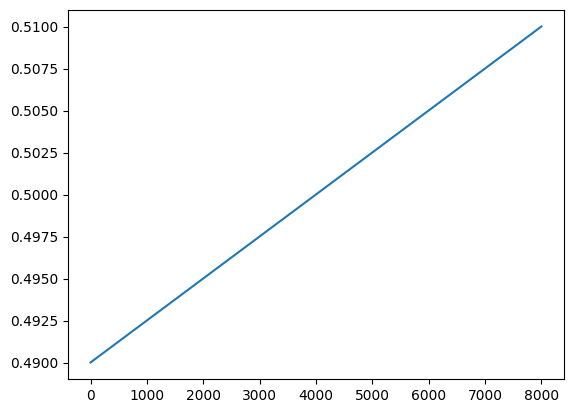

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(full_u[:,4000])


In [80]:


fig1 = plt.figure(figsize=(15,15))
ax0 = fig1.add_subplot(111)
x=np.linspace(0,5,559)
y=np.linspace(0,558,559)
X,Y= np.meshgrid(x,y)
c=ax0.pcolormesh(X, Y, full_a, cmap='hot', shading='auto')


array([[0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
        0.5000125],
       [0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
        0.5000125],
       [0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
        0.5000125],
       ...,
       [0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
        0.5000125],
       [0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
        0.5000125],
       [0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
        0.5000125]])

In [74]:
a_train, a_test, u_train, u_test = train_test_split(
    # torch.tensor(full_a),
    # torch.tensor(full_u),
    torch.from_numpy(full_a),
    torch.from_numpy(full_u),
    test_size=0.33,
    random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
batch_size = 20

a_train = a_train.reshape(*a_train.shape, 1)
# u_train = u_train.reshape(*u_train.shape, 1)

a_test = a_test.reshape(*a_test.shape, 1)
#u_test = u_test.reshape(*a_test.shape, 1)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(a_train, u_train),
    batch_size=batch_size,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(a_test, u_test),
    batch_size=batch_size,
    shuffle=False)

In [ ]:
modes = 16
width = 64

# model = FNO1d(modes, width).cuda()
model = FNO1d(modes, width).double().cuda()
# print(count_params(model))

In [ ]:
def train_model(
        epochs,
        loss,
        optimizer,
        scheduler):
    for epoch in tqdm(range(epochs)):
        model.train()
        t1 = timeit.default_timer()
        train_mse = 0
        train_l2 = 0

        for x, y in tqdm(train_loader):
            # x, y = x.cuda(), y.cuda()
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            mse = F.mse_loss(
                out.view(batch_size, -1),
                y.view(batch_size, -1),
                reduction='mean')
            l2 = loss(
                out.view(batch_size, -1),
                y.view(batch_size, -1))
            l2.backward()

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in tqdm(test_loader):
                # x, y = x.cuda(), y.cuda()
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += loss(
                    out.view(batch_size, -1),
                    y.view(batch_size, -1)).item()

        train_mse /= len(train_loader)
        train_l2 /= u_train.shape[0]
        test_l2 /= u_test.shape[0]

        t2 = timeit.default_timer()
        print(epoch, t2-t1, train_mse, train_l2, test_l2)

In [27]:
from Adam import Adam

In [ ]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [ ]:
learning_rate = 0.001
step_size = 50
gamma = 0.5
optimizer = Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma)

myloss = LpLoss(size_average=False)

In [ ]:
torch.backends.cpu.get_cpu_capability()
# torch.backends.nnpack.enabled = False

'NO AVX'

In [ ]:
train_model(
    20,
    myloss,
    optimizer,
    scheduler)

  0%|                                                            | 0/20 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# def gen_burgers_fisher_init_cond(alpha=0, delta=1, n_pts=10000):
#     a = 0.
#     b = 1.
#     dx = (b - a) / (n_pts - 1)
#     x = np.zeros(n_pts)
#     x = np.asarray([a + k*dx for k in range(n_pts)])

#     return (0.5 + 0.5*np.tanh((-alpha*delta/(delta+1)*0.5*x)))**(1./delta)

In [ ]:
# def gen_burgers_fisher_sol(
#         alpha=1.,
#         beta=0.0001,
#         delta=1.,
#         t_max=1.,
#         n_pts=10000,
#         n_time_slices=1000):
#     a = 0.
#     b = 1.
#     dx = (b - a) / (n_pts - 1)
#     x = np.zeros(n_pts)
#     x = np.asarray([a + k*dx for k in range(n_pts)])
#     arr = np.empty((n_time_slices, n_pts))

#     dt = t_max / (n_time_slices - 1)

#     for k in range(n_time_slices):
#         t = k*dt
#         arr[k, :] = (0.5
#                   + 0.5*np.tanh((-alpha*delta/(delta+1)*0.5*(
#                       x - (alpha/(delta+1) + beta*(delta+1)/alpha)*t))))**(1./delta)

#     return arr

In [ ]:
# gen_burgers_fisher_sol(
#         alpha=1., beta=0.0001, delta=1, t_max=1., n_pts=10000, n_time_slices=1000)

In [ ]:
def gen_burgers_fisher_sol(
        alpha=1.,
        beta=0.0001,
        delta=1.,
        t_max=1.,
        n_pts=10000):
    a = 0.
    b = 1.
    dx = (b - a) / (n_pts - 1)
    x = np.zeros(n_pts)
    x = np.asarray([a + k*dx for k in range(n_pts)])
    arr = np.empty((1, n_pts))

    arr[0, :] = (0.5
                 + 0.5*np.tanh((-alpha*delta/(delta+1)*0.5*(
                     x - (alpha/(delta+1) + beta*(delta+1)/alpha)*t_max))))**(1./delta)

    return arr

In [ ]:
import itertools


def generate_solution_matrix(
        alpha_range, beta_range, delta_range, t_max, n_pts):
    rng = list(itertools.product(alpha_range, beta_range, delta_range))
    arr = np.empty((len(rng), n_pts))
    # arr = np.empty((n_pts, len(rng)))

    for k, (alpha, beta, delta) in enumerate(rng):
        arr[k, :] = gen_burgers_fisher_sol(
            alpha, beta, delta, t_max, n_pts)
        # arr[:, k] = gen_burgers_fisher_sol(
        #     alpha, beta, delta, t_max, n_pts)

    return arr

In [ ]:
def equidistant_val_array(start, end, n_pts):
    a = start
    b = end
    dx = (b - a) / (n_pts - 1)
    x = np.zeros(n_pts)
    x = np.asarray([a + k*dx for k in range(n_pts)])

    return x

In [ ]:
# alphas = equidistant_val_array(-10, 10, 20)
alphas = [-0.0001]  # , 0.0001, 1, 500
# alphas
betas = equidistant_val_array(-0.4, 0.4, 8000)
# betas
deltas = [1]  # , 2, 3

In [ ]:
# res = generate_solution_matrix(
#         alphas, betas, deltas, 0., 10001)

In [ ]:
# import pandas as pd


# full_a = pd.read_csv('gen-burgers-fisher-t0-small-out.csv')
# full_u = pd.read_csv('gen-burgers-fisher-t0.1-small-out.csv')
# # train_data.head()

In [ ]:
# full_a.shape

(10001, 8000)

In [ ]:
# full_a[:, 20]

array([0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
       0.5000125])

In [ ]:
# full_u[:, 20]

array([0.49005132, 0.49005132, 0.49005132, ..., 0.49006381, 0.49006381,
       0.49006381])

In [ ]:
# equidistant_val_array(-1., 1., 10001)[1] - equidistant_val_array(-1., 1., 10001)[0]
# equidistant_val_array(-1., 1., 10000)
# equidistant_val_array(-1., 1., 10001)[0]

0.00019999999999997797

In [ ]:
# 2/(10001-1)

0.0002

In [ ]:
# full_a.head(2)

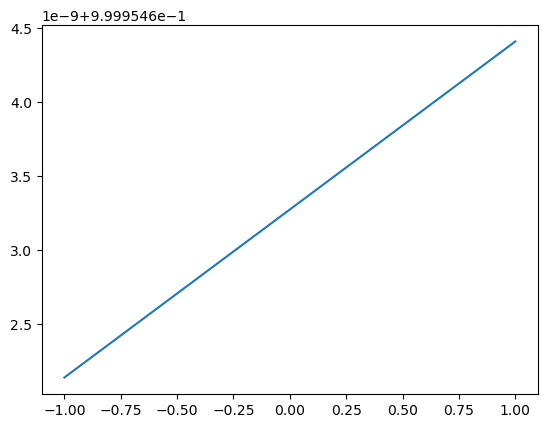

In [ ]:
# plt.plot(equidistant_val_array(-1, 1, 10001), gen_burgers_fisher_sol(
#     -0.0001, 0.2, 1., t_max=50, n_pts=10001)[0])

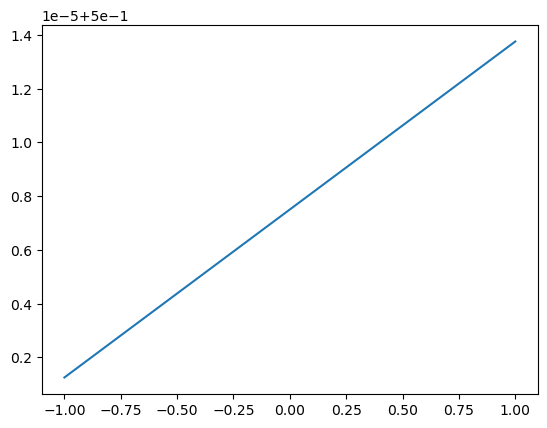

In [ ]:
# plt.plot(equidistant_val_array(-1, 1, 10000), res[:, 4000])

In [ ]:
# print(gen_burgers_fisher_sol(
#             0.0001, 0.001, t_max=50, n_pts=10000))

[[0.51249743 0.51249743 0.51249743 ... 0.51248494 0.51248494 0.51248494]]


In [ ]:
# np.savetxt(
#     'gen-burgers-fisher-t0-small-out.csv',
#     res,  # res.T,
#     # header=','.join(["x", "y", "z"]),
#     delimiter=',',
#     # fmt='%.0f',
#     comments='')

In [ ]:
# del res